**AdaBoost классификатор** 

Евгений Борисов  <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

## генерируем данные

In [3]:
n_samples = 500

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=n_samples, centers=2,  cluster_std=[1.5, 1.8,] )

from sklearn.datasets import make_moons
X,target = make_moons(n_samples=n_samples, noise=.09)

y = (target*2-1) #[:,np.newaxis]

X.shape, y.shape

((500, 2), (500,))

In [4]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [5]:
# np.percentile(X,[10,25,50,75,95],axis=0) 

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250,), (250, 2), (250,))

In [7]:
del X
del y
del target

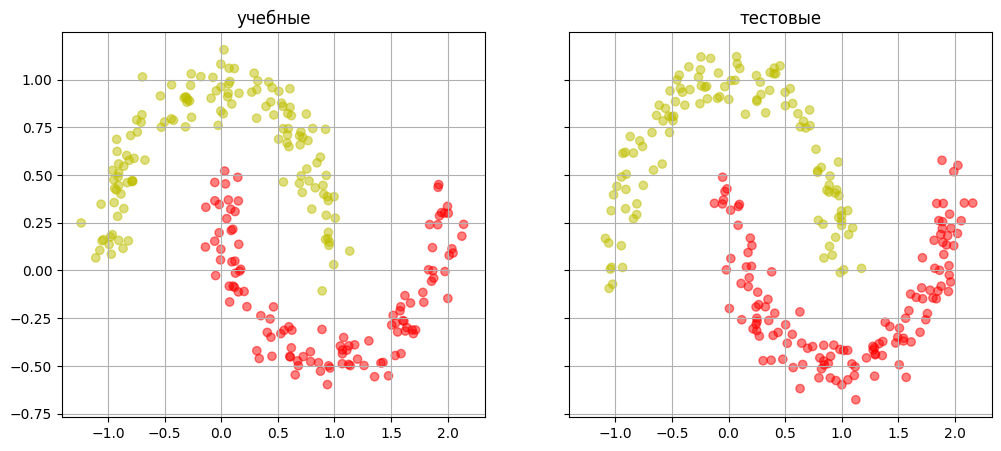

In [8]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y.flatten()  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')    
plot_data(ax1,X_test,y_test,'тестовые')    
plt.show()

In [9]:
# X = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
# y = y*2-1

## модель

In [10]:
# пороговый классификатор отказами
#    вход, номер признака, порог, знак классификатора [-1,0,1]
def stumb(X,i,b,s): 
    return s*np.sign(X[:,i]-b)

In [11]:
# взвешенная суммарная ошибка классификатора h
def err_count(X,i,b,s,w,y): 
    o = stumb(X,i,b,s) # ответ классификатора
    r = o*y<0 # ответ ошибочный и не отказ (!=0)
    return (r*w).sum() # взвешенная суммарная ошибка

# разделение набора с наименьшей ошибкой
#    вход, веса примеров, знак классификатора, метки примеров, количество порогов для выбора 
def search_split(X,w,s,y,nb=30):
    # список порогов для каждого признака
    b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] 
                    for i in range(X.shape[1]) ])
    
    # количество ошибок для разных признаков и значений порогов 
    err = np.array([ 
        [ err_count(X,i,b[i,j],s,w,y) for i in range(X.shape[1]) ]     
        for j in range(b.shape[1]) 
    ])
    
    # параметры с минимальным значением ошибок
    j,i = np.unravel_index(err.argmin(),err.shape)

    return i,b[i,j],err[j,i] # номер признака, порог, значение ошибки

def stumb_train (X,w,y):
    # классификатор y=[x>b]
    i0,b0,err0 = search_split(X_train,w,1,y_train)
    # классификатор y=[x<b]
    i1,b1,err1 = search_split(X_train,w,-1,y_train)
    
    # выбираем классификатор с меньшей ошибкой
    i,b,s = (i0,b0,1) if (err0<err1) else (i1,b1,-1)
    
    return i,b,s

In [12]:
def score(x,rules): 
    return np.sum([ a*stumb(x,i,b,s) for a,i,b,s in rules ],axis=0)

# ответ композиции классификаторов rules для входа x
def predict(x,rules): 
    return np.sign(score(x,rules))

In [13]:
# значение ф-ции потери для композиции классификаторов r для входа X и меток y
def loss(x,rules,y): 
    return np.exp(-y* score(x,rules) ).sum()/len(y)

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
n_samples = len(y_train) # количество примеров
n_epoch = 200 # максимальное число циклов обучения
acc_min = .98 # порог минимально допустимой погрешности модели
n_param = X_train.shape[1] # размер вектора признаков

In [16]:
# веса объектов учебной выборки
w = np.ones(n_samples)/n_samples
rules = [] # параметры классификаторов композиции
# ERR_BOUND=0.07 # порог ошибки

In [17]:
# начальное значение ф-ции потери
loss_history = []
acc_history = []

In [18]:
d = 1./n_samples # добавка для расчёта веса компоненты на случай отсутствия ошибок 

for jj in range(n_epoch):
    i,b,s = stumb_train(X_train,w,y_train) # обучаем базовый классификатор
    o = stumb(X_train,i,b,s) # ответ обученного базового классификатора
        
    p = ((o*y_train>0)*w).sum() # сумма весов правильных ответов
    n = ((o*y_train<0)*w).sum() # сумма весов ошибочных ответов
    # (o==0).sum() # количество отказов
    
    # базовый классификатор должен выдавать результат лучше чем случайный выбор 
    if( n > .5 ): 
        print('step %i/%i: acc new stumb less 0.5\n'%(jj+1,n_epoch))
        break 
      
    a = np.log((p+d)/(n+d))/2. # вычисляем вес классификатора
    
    rules.append([a,i,b,s]) # добавляем классификатор в композицию
     
    loss_history.append(loss(X_train,rules,y_train)) # значение потери композиции
    acc_history.append( accuracy_score( y_train,predict(X_train,rules)) ) # значение погрешности композиции
    if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
        print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(jj+1,n_epoch,loss_history[-1],acc_min))
        break
        
    # обновляем веса объектов
    w = w*np.exp( -a*y_train*o )
    w = w/w.sum()


step 16/200: loss 0.111, acc threshold 0.980 reached



In [19]:
# нормируем веса классификаторов
a_sum = sum([ r[0] for r in rules ])
rules = [ [a/a_sum,i,b,s] for a,i,b,s in rules ]

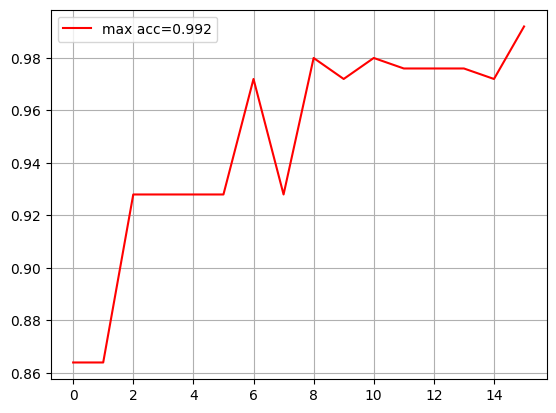

In [20]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)),c='r')
plt.grid()
plt.legend()

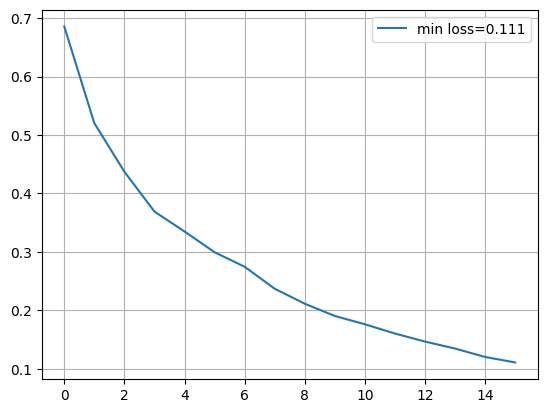

In [21]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

## тестируем модель

In [22]:
s = score(X_test,rules)

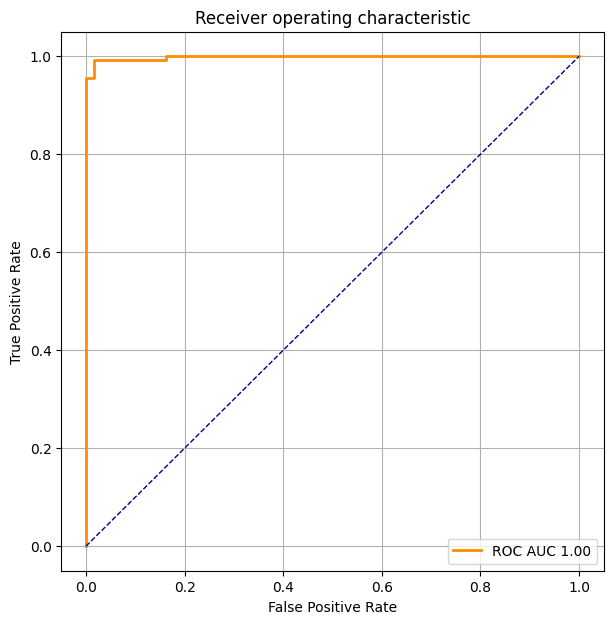

In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve( y_test, s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [24]:
# оптимальный порого скора 
#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
optimal_threshold

0.02574122063560314

In [25]:
p = (s>optimal_threshold).astype(int)
y = (y_test>0).astype(int)

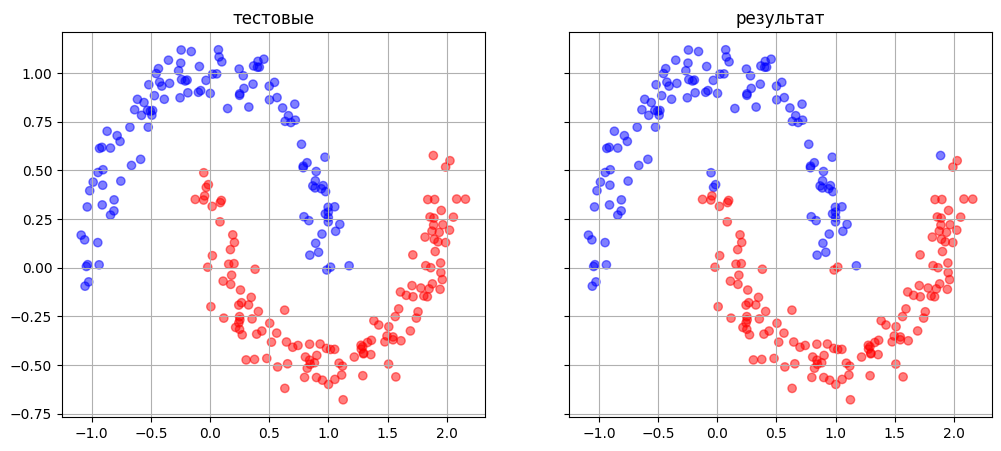

In [26]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y,'тестовые')    
plot_data(ax1,X_test,p,'результат')    
plt.show()

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y,p))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       117
           1       0.98      0.97      0.98       133

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



## карта скоров

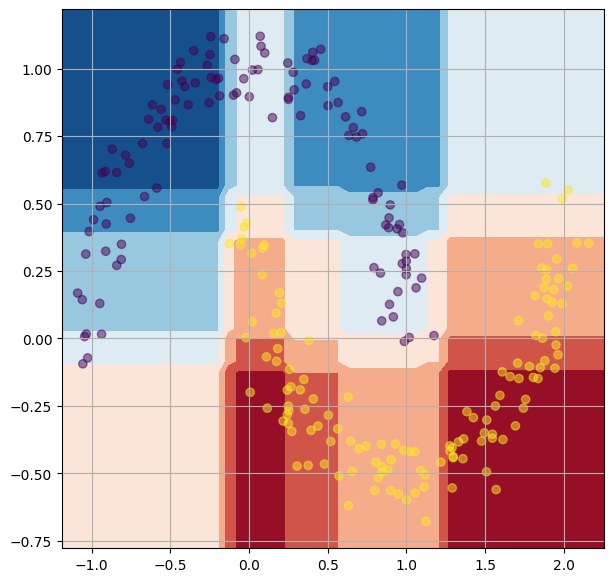

In [28]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 

s = score(xy,rules)

plt.figure(figsize=(7,7))
plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=.5 )
plt.grid()